<a href="https://colab.research.google.com/github/vasylcf/DLAI/blob/master/IT_Weekend_Workshop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Check GPU access

In [0]:
!nvidia-smi

Sun Oct 20 22:22:03 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.40       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    62W / 149W |   4299MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

## Mute new PyTorch-Fast.ai warnings

In [0]:
import warnings
warnings.filterwarnings('ignore')

## And import required libraries

In [0]:
from fastai import vision
import numpy as np

# Part 1 - Semantic Segmentation (Fast.ai tutorial)

## Data

In [0]:
path = vision.untar_data(vision.URLs.CAMVID)
path_lbl = path/'labels'
path_img = path/'images'
fnames = vision.get_image_files(path_img)

In [0]:
# Function to get masks
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

Image shape torch.Size([3, 720, 960]), mask shape torch.Size([1, 720, 960])


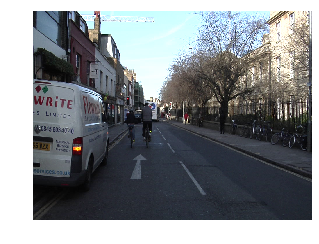

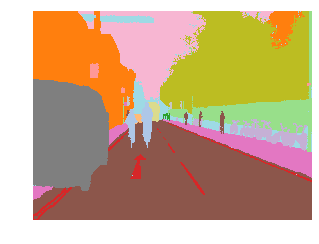

In [0]:
img_f = fnames[0]
img = vision.open_image(img_f)
img.show(figsize=(5, 5))
mask = vision.open_mask(get_y_fn(img_f))
mask.show(figsize=(5, 5), alpha=1)

print("Image shape {}, mask shape {}".format(img.shape, mask.shape))

In [0]:
codes = np.loadtxt(path/'codes.txt', dtype=str)
codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

## Dataset

In [0]:
src_size = np.array(mask.shape[1:])
size = src_size//4
bs = 16

In [0]:
src = (vision.SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, 
                        classes=codes)
      )

In [0]:
transforms = vision.get_transforms()
data = (src.transform(transforms, size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(vision.imagenet_stats))

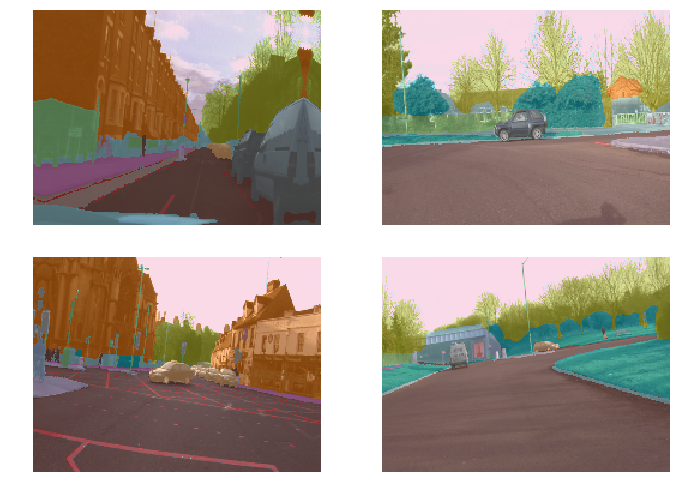

In [0]:
data.show_batch(2, figsize=(10, 7))

## Model

In [0]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

### Create model with resnet34 backbone and cross entropy loss

In [0]:
learn = vision.unet_learner(data=data, 
                            arch=vision.models.resnet34, # unet backbone
                            metrics=acc_camvid)

In [0]:
# Check loss function
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

### Train the model

In [0]:
learn.fit_one_cycle(5, slice(1e-3))

epoch,train_loss,valid_loss,acc_camvid,time
0,1.505435,0.973796,0.778744,01:08
1,1.159432,0.771792,0.826765,00:45
2,0.898479,0.634333,0.842858,00:45
3,0.739334,0.541543,0.855215,00:45
4,0.651834,0.533620,0.855379,00:45


### Visualize results

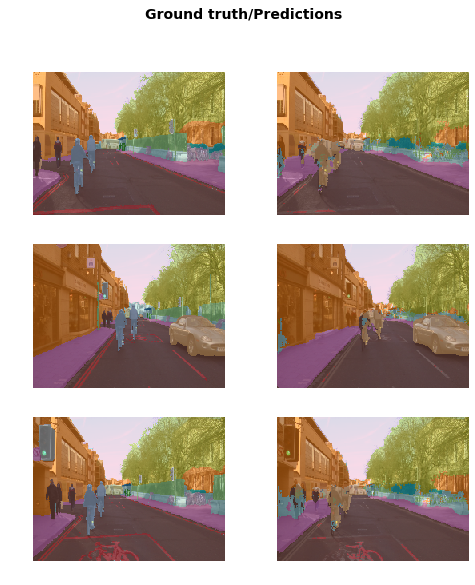

In [0]:
learn.show_results(rows=3, figsize=(8, 9))

# Part 2 - Objects Counting

## Data download

In [0]:
!gdown https://drive.google.com/uc?id=1c2DbpaZZVWlVXunWFfIAPqB5OOkKo7xE

Downloading...
From: https://drive.google.com/uc?id=1c2DbpaZZVWlVXunWFfIAPqB5OOkKo7xE
To: /content/sunflower-data.zip
7.73MB [00:00, 68.0MB/s]


In [0]:
!unzip -qq sunflower-data.zip

replace sunflower-data/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [0]:
!ls

__MACOSX    palms-data-512.zip	sample_data	sunflower-data.zip
palms-data  palms-data.zip	sunflower-data


## Data paths

In [0]:
from pathlib import PosixPath

path = PosixPath('sunflower-data/')
path_img = path/'images'
path_lbl = path/'masks'

fnames = vision.get_image_files('sunflower-data/images')

In [0]:
get_y_fn = lambda x: path_lbl/f'{x.stem}.png'

## Gaussian kernel

In [0]:
def _gaussian_k(x0, y0, sigma, width, height):
    """ Make a square gaussian kernel centered at (x0, y0) with sigma as SD.
    """
    x = np.arange(0, width, 1, float)  ## (width,)
    y = np.arange(0, height, 1, float)[:, np.newaxis]  ## (height,1)
    return np.exp(-((x - x0) ** 2 + (y - y0) ** 2) / (2 * sigma ** 2))
  
def gaussian_mask(label):
    mask_np = np.asarray(label)[:, :, 0]
    x, y = np.where(mask_np > 0)
    coordinates = list(zip(x, y))
    heatmap = np.zeros(mask_np.shape)
    
    for coordinate in coordinates:
        heatmap += _gaussian_k(x0=coordinate[1],
                               y0=coordinate[0],
                               sigma=4,
                               width=mask_np.shape[1],
                               height=mask_np.shape[0])
    return heatmap * 255

## Data loader

In [0]:
src = (vision.ImageImageList.from_folder(path_img)
       .split_subsets(0.8, 0.2)
       .label_from_func(get_y_fn, after_open=gaussian_mask)
      )

In [0]:
src

LabelLists;

Train: LabelList (40 items)
x: ImageImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: ImageList
Image (1, 512, 512),Image (1, 512, 512),Image (1, 512, 512),Image (1, 512, 512),Image (1, 512, 512)
Path: sunflower-data/images;

Valid: LabelList (10 items)
x: ImageImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: ImageList
Image (1, 512, 512),Image (1, 512, 512),Image (1, 512, 512),Image (1, 512, 512),Image (1, 512, 512)
Path: sunflower-data/images;

Test: None

In [0]:
size = 512
bs = 1
transforms = vision.get_transforms()
data = (src.transform(transforms, size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(vision.imagenet_stats, do_y=False))
data.c = 1

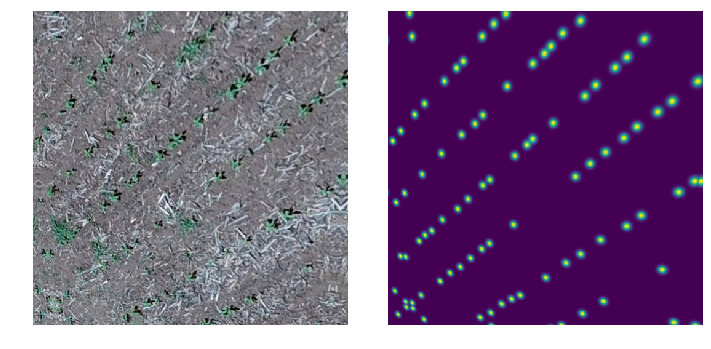

In [0]:
data.show_batch(ds_type=vision.DatasetType.Train, rows=2, figsize=(10, 7))

In [0]:
from torch import nn
import torch

class L2Loss(nn.Module):
    def __init__(self, use_sigmoid: bool=False):
        super(L2Loss, self).__init__()
        self.use_sigmoid = use_sigmoid
        self.mse = nn.MSELoss()

    def forward(self, input, target):
        if self.use_sigmoid:
          input = torch.sigmoid(input)
        loss = self.mse(input, target)
        return loss.mean() + np.finfo(float).eps

## Model

In [0]:
loss = L2Loss()
learn = vision.unet_learner(data=data, 
                            arch=vision.models.resnet34, # unet backbone
                            loss_func=loss,
                            y_range=(.0, 1.),
                            norm_type=vision.NormType.Batch)
learn.last_cross = False
learn.blur_final = False
learn.unfreeze()

In [0]:
learn.fit_one_cycle(15, 1e-3)

epoch,train_loss,valid_loss,time
0,0.238395,0.232527,00:30
1,0.214126,0.202316,00:30
2,0.202789,0.187464,00:30
3,0.193748,0.173049,00:30
4,0.184928,0.167096,00:30
5,0.175794,0.153101,00:30
6,0.167354,0.154187,00:30
7,0.159793,0.148789,00:30
8,0.153656,0.147338,00:30
9,0.148112,0.136934,00:30


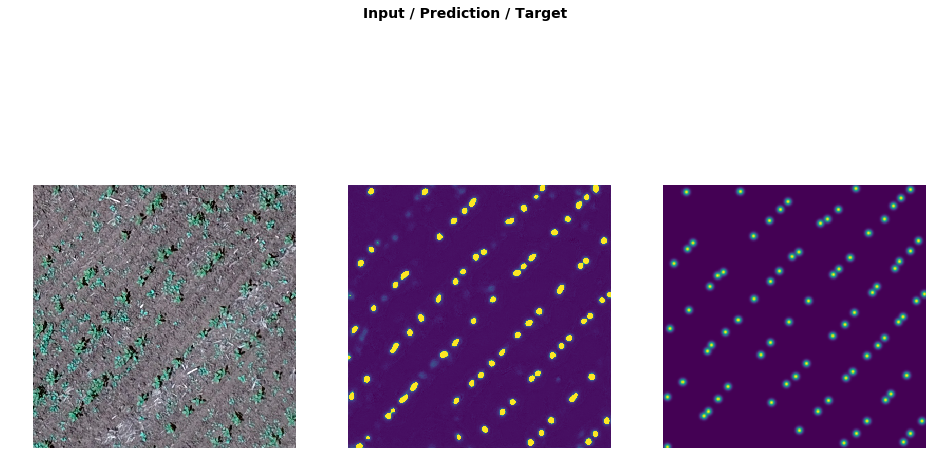

In [0]:
learn.show_results(ds_type=vision.DatasetType.Valid, rows=1, figsize=(16, 9))

## Calculate number of plants in the image

### Find gaussians

In [0]:
from skimage.feature import blob_log

def find_blobs(mask: np.array):
    im = (mask * 255).astype('uint8')
    blobs = blob_log(im, min_sigma=4, max_sigma=5, num_sigma=1,
                     threshold=0.08)
    coordinates = [(int(blob[0]), int(blob[1])) for blob in blobs]
    return vision.ImagePoints(vision.FlowField((mask.shape), vision.Tensor(coordinates))), len(coordinates)
  

In [0]:
index = 5
image = src.valid[index][0]
blobs, num = find_blobs(learn.predict(image)[1].numpy()[0])

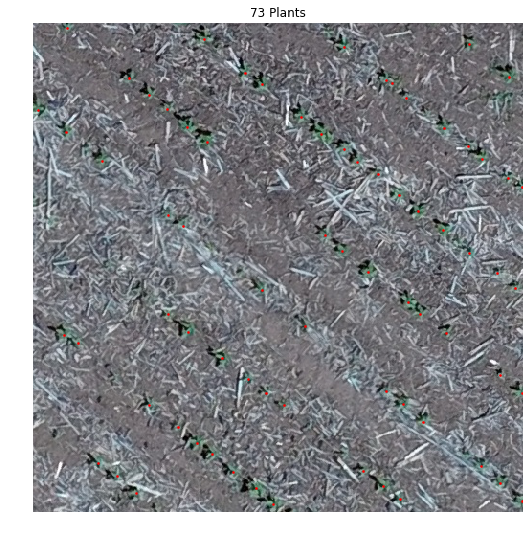

In [0]:
image.show(y=blobs, figsize=(16,9), title='{} Plants'.format(num))